## XGBoostで予測

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn.preprocessing as sp
from sklearn import datasets
from sklearn.metrics import confusion_matrix, mean_squared_error

In [28]:
df = pd.read_csv("./data/cleansed_ver2.csv" ,encoding = "utf-8")
df = df.drop(["Unnamed: 0",'index'], axis = 1)
#表示列の増加
pd.set_option('display.max_columns', 162)
df.head()

,Median_Age,Mean_Age,Male,Any_Comorbidity,Fever_temperature_373C,Cough,Chronic_obstructive_lung_COPD,Diabetes,Hypertension,Cardiovascular_Disease_incl_CAD,Fatigue,Other,Shortness_of_Breath_dyspnoea,Smoking_history,BMI,Cancer_Any,Asian,Cerebrovascular_Disease,Diarrhoea,Mortality,Positivenegative_cases_Negative only,Positivenegative_cases_Positive,Positivenegative_cases_Positive Only,Positivenegative_cases_Positive and Negative/Unconfirmed,Positivenegative_cases_Positive only,danger_level
0,56.0,50.680772,62.30,47.60,94.00,79.00,3.00,19.00,30.00,8.00,23.03,12.00,0.0,5.76,0.0,1.68,100.0,0.0,4.71,0.28,0,0,0,0,1,5
1,69.0,50.680772,70.37,66.67,94.44,72.22,7.41,31.48,48.15,24.07,27.78,20.37,0.0,9.26,0.0,0.00,100.0,0.0,3.70,1.00,0,0,0,0,1,6
2,52.0,50.680772,59.12,40.15,94.16,81.75,1.46,13.87,23.36,1.46,21.17,8.03,0.0,4.38,0.0,7.00,100.0,0.0,5.11,0.00,0,0,0,0,1,1
3,58.0,50.680772,60.30,0.00,91.50,0.00,0.00,11.60,0.00,0.00,0.00,0.00,0.0,0.00,0.0,3.00,100.0,6.5,2.06,0.16,0,0,0,0,1,4
4,58.0,50.680772,61.60,0.00,89.90,0.00,0.00,10.10,0.00,0.00,0.00,0.00,0.0,0.00,0.0,5.10,100.0,5.1,4.20,0.15,0,0,0,0,1,4


In [29]:
#XGBoost
import xgboost as xgb

In [30]:
from sklearn.model_selection import train_test_split
X = df.drop(['danger_level','Mortality'], axis=1)
y = df['danger_level']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=4)

In [31]:
dtrain = xgb.DMatrix(X_train, label=y_train)
param = {'max_depth': 4, 
         'eta': 1, 
         'objective': 'multi:softmax', 
         'num_class': 7}
num_round = 10
bst = xgb.train(param, dtrain, num_round)
dtest = xgb.DMatrix(X_test)
pred = bst.predict(dtest)

In [32]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_test, pred)
print('score:{0:.4f}'.format(score))

score:0.7204


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

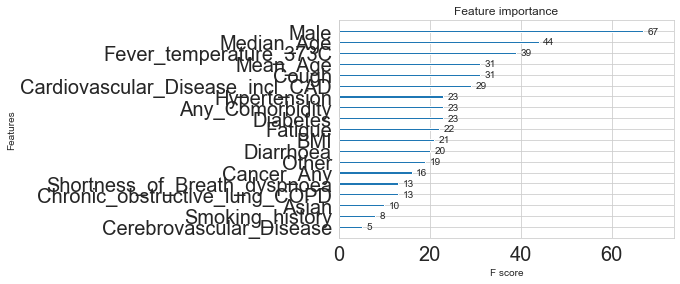

In [33]:
xgb.plot_importance(bst)

In [34]:
model = xgb.XGBRegressor(objective ='reg:squarederror')
model.fit(X_train,y_train)

XGBRegressor(objective='reg:squarederror')

In [35]:
# 自由度調整済みr2を算出
def adjusted_r2(X,Y,model):
    from sklearn.metrics import r2_score
    import numpy as np
    r_squared = r2_score(Y, model.predict(X))
    adjusted_r2 = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
    #yhat = model.predict(X) \ #SS_Residual = sum((Y-yhat)**2) \ #SS_Total = sum((Y-np.mean(Y))**2)
    #r_squared = 1 - (float(SS_Residual))/ SS_Total
    return adjusted_r2

# 予測モデルの精度確認の各種指標を算出
def get_model_evaluations(X_train,Y_train,X_test,Y_test,model):
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import median_absolute_error

   # 評価指標確認
   # 参考: https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/
    yhat_test = model.predict(X_test)
    return "adjusted_r2(train)     :" + str(adjusted_r2(X_train,Y_train,model)) \
         , "adjusted_r2(test)      :" + str(adjusted_r2(X_test,Y_test,model)) \
         , "平均誤差率(test)       :" + str(np.mean(abs(Y_test / yhat_test - 1))) \
         , "MAE(test)              :" + str(mean_absolute_error(Y_test, yhat_test)) \
         , "MedianAE(test)         :" + str(median_absolute_error(Y_test, yhat_test)) \
         , "RMSE(test)             :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test))) \
         , "RMSE(test) / MAE(test) :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test)) / mean_absolute_error(Y_test, yhat_test)) #better if result = 1.253

In [36]:
get_model_evaluations(X_train,y_train,X_test,y_test,model)

('adjusted_r2(train)     :0.891525772588128',
 'adjusted_r2(test)      :0.5024377109977247',
 '平均誤差率(test)       :0.36209015090215907',
 'MAE(test)              :0.831298473060772',
 'MedianAE(test)         :0.6040840148925781',
 'RMSE(test)             :1.1475878669947635',
 'RMSE(test) / MAE(test) :1.380476332128267')

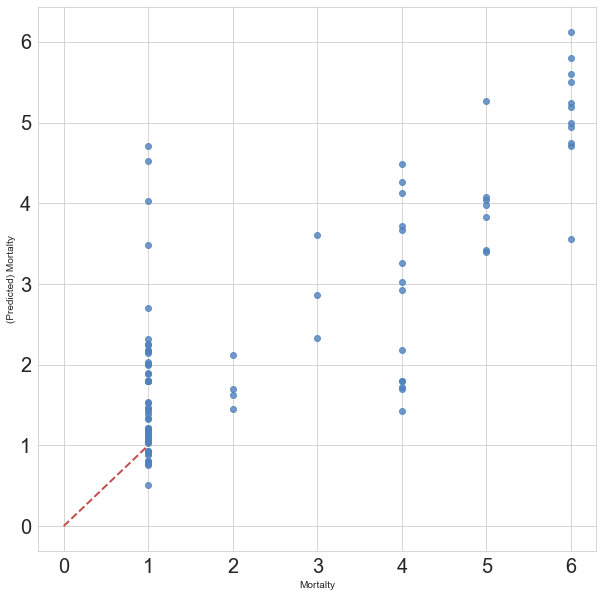

In [37]:
# 描画設定
from matplotlib import rcParams
rcParams['xtick.labelsize'] = 20       # x軸のラベルのフォントサイズ
rcParams['ytick.labelsize'] = 20       # y軸のラベルのフォントサイズ
rcParams['figure.figsize'] = 10,10      # 画像サイズの変更(inch)

import matplotlib.pyplot as plt
from matplotlib import ticker
sns.set_style("whitegrid")             # seabornのスタイルセットの一つ
sns.set_color_codes()                  # デフォルトカラー設定 (deepになってる)

plt.figure()
ax = sns.regplot(x=y_test, y=model.predict(X_test), fit_reg=False,color='#4F81BD')
ax.set_xlabel(u"Mortalty")
ax.set_ylabel(u"(Predicted) Mortalty")
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
ax.plot([0,0.5,1],[0,0.5,1], linewidth=2, color="#C0504D",ls="--")

## もういっかい

In [73]:
df = pd.read_csv("./data/cleansed.csv" ,encoding = "utf-8")
df = df.drop("Unnamed: 0", axis = 1)
#表示列の増加
pd.set_option('display.max_columns', 162)
df.columns

Index(['Median_Age', 'Mean_Age', 'Male', 'Any_Comorbidity',
       'Fever_temperature_373C', 'Cough', 'Chronic_obstructive_lung_COPD',
       'Diabetes', 'Hypertension', 'Cardiovascular_Disease_incl_CAD',
       'Fatigue', 'Other', 'Shortness_of_Breath_dyspnoea', 'Smoking_history',
       'BMI', 'Cancer_Any', 'Asian', 'Cerebrovascular_Disease', 'Diarrhoea',
       'Mortality', 'Positivenegative_cases_Negative only',
       'Positivenegative_cases_Positive',
       'Positivenegative_cases_Positive Only',
       'Positivenegative_cases_Positive and Negative/Unconfirmed',
       'Positivenegative_cases_Positive only'],
      dtype='object')

In [60]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=4)

#訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
X_train = train_set.drop('Mortality', axis=1)
y_train = train_set['Mortality']
 
#モデル評価用データを説明変数データ(X_train)と目的変数データ(y_train)に分割
X_test = test_set.drop('Mortality', axis=1)
y_test = test_set['Mortality']

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    3.9s finished


{'max_depth': 4, 'n_estimators': 100} 0.6244442649985039
[11:16:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.003984574118793379
0.022482943772985944


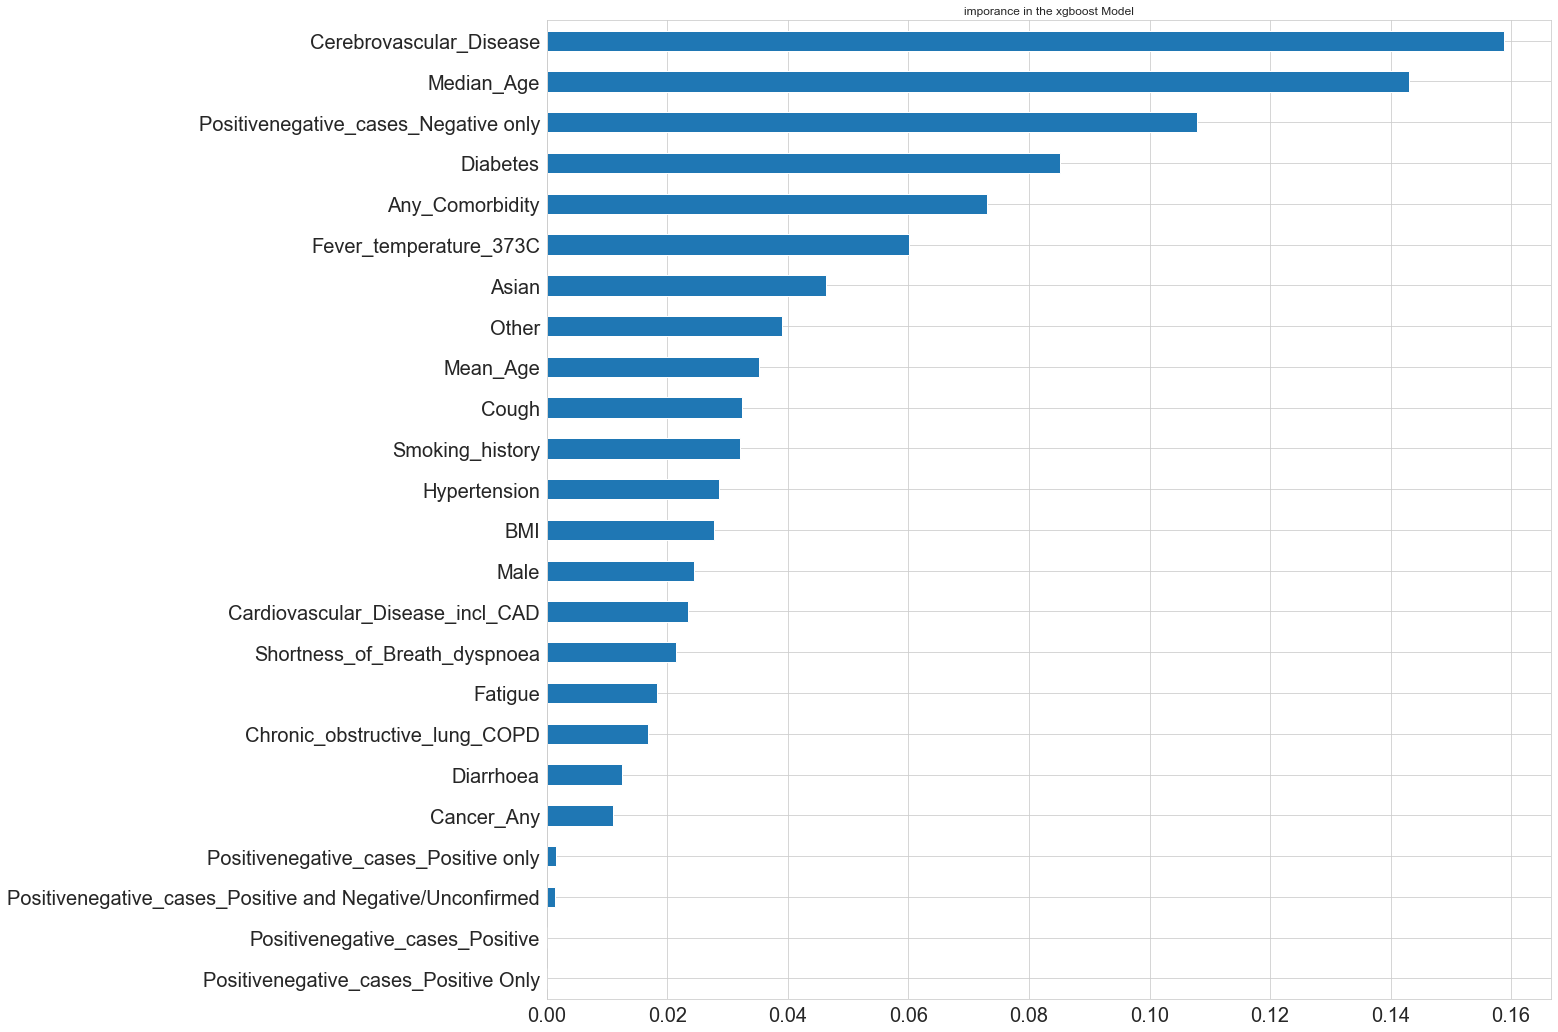

In [75]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error


reg = xgb.XGBRegressor(objective ='reg:squarederror')

# ハイパーパラメータ探索
reg_cv = GridSearchCV(reg, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
reg_cv.fit(X_train, y_train)
print (reg_cv.best_params_, reg_cv.best_score_)

# 改めて最適パラメータで学習
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(X_train, y_train)

# 学習モデルの保存、読み込み
# import pickle
# pickle.dump(reg, open("model.pkl", "wb"))
# reg = pickle.load(open("model.pkl", "rb"))

# 学習モデルの評価
pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)
print (mean_squared_error(y_train, pred_train))
print (mean_squared_error(y_test, pred_test))

# feature importance のプロット
import pandas as pd
import matplotlib.pyplot as plt
importances = pd.Series(reg.feature_importances_, index = X_train.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

In [83]:
df = pd.read_csv("./data/cleansed.csv" ,encoding = "utf-8")
df = df.drop("Unnamed: 0", axis = 1)
#表示列の増加
#pd.set_option('display.max_columns', 162)
#df.columns

In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb

df_except_y = df.drop(["Mortality"], axis=1)
X = df_except_y.values

# 目的変数に "y " を利用
y = df['Mortality'].values

# 必要なライブラリのインポート
from sklearn.model_selection import GridSearchCV
# 動かすパラメータを明示的に表示
params = {"learning_rate":[0.1,0.3,0.5],
        "max_depth": [2,3,5,10],
         "subsample":[0.5,0.8,0.9,1],
         "colsample_bytree": [0.5,1.0],
         }
# モデルにインスタンス生成
mod = xgb.XGBRegressor(objective ='reg:squarederror')
# ハイパーパラメータ探索
#回帰なのでr2
cv = GridSearchCV(mod, params, cv = 10, scoring= 'r2', n_jobs =-1)

#　trainデータとtestデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# 予測モデルを作成
cv.fit(X_train, y_train)

#予測    
y_train_pred = cv.predict(X_train)
y_test_pred = cv.predict(X_test)

In [121]:
cv.score(X_test,y_test)

0.5883264278420994

In [122]:
print("Best parameters: %s" % cv.best_params_)
print("Best auroc score: %s" % cv.best_score_)

Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'subsample': 0.9}
Best auroc score: 0.6550276185631685
